# Regression of Transport coefficients with Neural Networks

In this notebook, the **shear viscosity** is regressed and predicted with a simple sequential NN architecture.

### Install modules

In [61]:
# some module may be missing ...
!pip install tensorflow==1.15.2 # could be troublesome to find (maybe it works also with newer versions)
!pip install livelossplot
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install seaborn
!pip install pandas
!pip install sklearn
!pip install ann_visualizer
!pip install keras-sequential-ascii
!pip install joblib

### Load modules

In [76]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
print(tf.__version__)

import sklearn
print(sklearn.__version__)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, minmax_scale, MaxAbsScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn import metrics

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

from keras_sequential_ascii import keras2ascii

import os;
path="."
os.chdir(path)
os.getcwd()

import csv
import time

from IPython.display import clear_output
from livelossplot import PlotLossesKeras

from ann_visualizer.visualize import ann_viz;

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

import pickle
from joblib import dump, load

import sys
sys.path.insert(0, './')

from plotting import newfig, savefig # the file plotting.py should be present

from matplotlib import rc
rc("text", usetex=False)

1.15.2
0.24.2


### Load database

In [63]:
# If the header is not present, we should not skip the first line
#dataset = np.loadtxt("../../../Data/TCs_air5.txt") # not efficient for big files
with open('./TCs_air5.txt') as f:
    lines = (line for line in f if not line.startswith('#'))
    dataset = np.loadtxt(lines, skiprows=1)

x = dataset[:,0:7] # T, P, x_N2, x_O2, x_NO, x_N, x_O
y = dataset[:,7:8] # shear viscosity

# dataset print info
in_dim  = x.shape[1]
out_dim = y.shape[1]
print("IN:", in_dim, "OUT:", out_dim)

IN: 7 OUT: 1


### Sanity plot of dataset

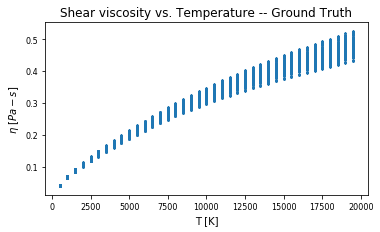

In [74]:
# 2D Plot
plt.scatter(x[:,0], y, s=0.5)
plt.title('Shear viscosity vs. Temperature -- Ground Truth')
plt.xlabel('T [K]')
plt.ylabel('$\eta$ $[Pa-s]$')
plt.tight_layout()
plt.savefig("shear_viscosity.pdf")
plt.show()

### Dataset train/test split

In [65]:
print("[INFO] Split data ...")
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, test_size=0.25, random_state=666)

[INFO] Split data ...


### Data standardization/normalization

In [66]:
print("[INFO] StandardScaling data ...")
sc_x = StandardScaler()
sc_y = StandardScaler()

sc_x.fit(x_train)
x_train = sc_x.transform(x_train)
x_test  = sc_x.transform(x_test)

sc_y.fit(y_train)
y_train = sc_y.transform(y_train)
y_test  = sc_y.transform(y_test)

# Save scalers
dump(sc_x, open('scaler_x.pkl', 'wb'))
dump(sc_y, open('scaler_y.pkl', 'wb'))

# Do not forget to inverse transforming back to the dimensional values at the end
#x_test_dim = sc_x.inverse_transform(x_test)
#y_test_dim = sc_y.inverse_transform(y_test)
#y_regr_dim = sc_y.inverse_transform(y_regr)

[INFO] StandardScaling data ...


### Model architecture

In [102]:
print("[INFO] Model build ...")
model = Sequential()
model.add(Dense(70, input_dim=in_dim, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.002), activation='relu'))
model.add(Dense(35, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
#model.add(Dropout(0.5))
model.add(Dense(15, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model.add(Dense(out_dim, activation='linear'))

# Optimizer
#opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.01)
#opt = keras.optimizers.Adam(learning_rate=0.01)
opt = keras.optimizers.Adam(learning_rate=0.01, decay=1e-3/100)

# Optional callbacks
model_path = './model.h5'
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
checkpoint = keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=False)
csv_logger = keras.callbacks.CSVLogger('training.log')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto', baseline=None, restore_best_weights=False)

# Model visualization
model.summary()

# Just another way to visualize the model
keras2ascii(model)

[INFO] Model build ...
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 70)                560       
_________________________________________________________________
dense_43 (Dense)             (None, 35)                2485      
_________________________________________________________________
dense_44 (Dense)             (None, 15)                540       
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 16        
Total params: 3,601
Trainable params: 3,601
Non-trainable params: 0
_________________________________________________________________
           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           7
               Dense   XXXXX -------------------       560    15.6%
                relu   #####          70
  

### Configure the model for training

In [103]:
model.compile(loss='mse', metrics=['mse', 'mae', 'mape', 'msle'], optimizer=opt)

### Train the model

In [104]:
print("[INFO] training model...")
history = model.fit(x_train, 
                    y_train, 
                    epochs=10, 
                    batch_size=64, 
                    verbose=2, 
                    validation_data=(x_test, y_test), 
                    callbacks=[tbCallBack,checkpoint,csv_logger,earlystopping])

[INFO] training model...
Train on 35100 samples, validate on 11700 samples
Epoch 1/10

Epoch 00001: val_loss improved from inf to 0.01801, saving model to ./model.h5
35100/35100 - 3s - loss: 0.0665 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0512 - mean_absolute_percentage_error: 18.2476 - mean_squared_logarithmic_error: 0.0016 - val_loss: 0.0180 - val_mean_squared_error: 7.4348e-04 - val_mean_absolute_error: 0.0171 - val_mean_absolute_percentage_error: 5.2827 - val_mean_squared_logarithmic_error: 4.3604e-05
Epoch 2/10

Epoch 00002: val_loss improved from 0.01801 to 0.01352, saving model to ./model.h5
35100/35100 - 2s - loss: 0.0154 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0261 - mean_absolute_percentage_error: 9.9926 - mean_squared_logarithmic_error: 1.4443e-04 - val_loss: 0.0135 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0260 - val_mean_absolute_percentage_error: 10.6450 - val_mean_squared_logarithmic_error: 1.7871e-04
Epoch 3/10

Epoch 00003

### Print keys' history

In [105]:
# Plot history keys
print(history.history.keys())

# Plot history 
history.history

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_squared_logarithmic_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'val_mean_absolute_percentage_error', 'val_mean_squared_logarithmic_error'])


{'loss': [0.06647123660690595,
  0.015421793371163032,
  0.0127018824100834,
  0.011126705372753816,
  0.009975937595246015,
  0.009368345336908968,
  0.009064758151578598,
  0.00877594762707283,
  0.00851904759931768,
  0.008363819525728369],
 'mean_squared_error': [0.0104984585,
  0.0012735421,
  0.0012770711,
  0.001212756,
  0.0014038675,
  0.0012459683,
  0.001112196,
  0.0010490201,
  0.0009752051,
  0.0010023029],
 'mean_absolute_error': [0.051181685,
  0.026103497,
  0.026789056,
  0.026167415,
  0.027993893,
  0.025878847,
  0.024529058,
  0.023871502,
  0.0229049,
  0.023238521],
 'mean_absolute_percentage_error': [18.247631,
  9.992563,
  10.746063,
  10.5077915,
  11.327997,
  10.904136,
  10.291769,
  10.548333,
  9.658707,
  9.571725],
 'mean_squared_logarithmic_error': [0.0016139017,
  0.00014442657,
  0.0001671429,
  0.00015930635,
  0.00018114835,
  0.00015316483,
  0.00013234126,
  0.00012309893,
  0.00010979876,
  0.00010711606],
 'val_loss': [0.018005583400272914,
 

### Plot error metrics

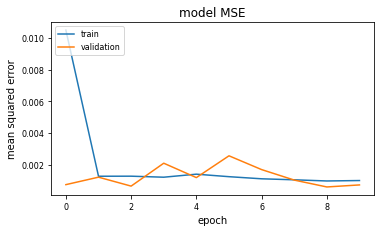

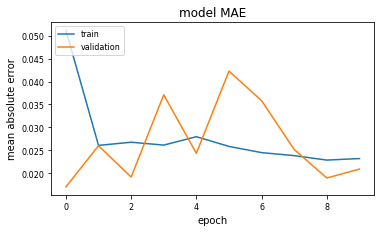

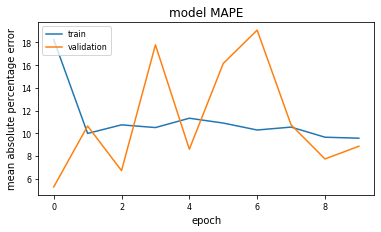

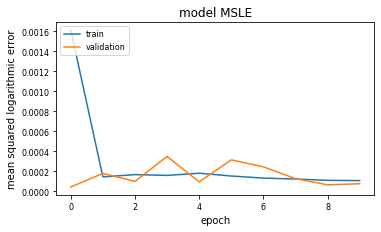

In [106]:
plt.figure()
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.savefig("MSE.pdf", dpi=150)
plt.show()

plt.figure()
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.savefig("MAE.pdf", dpi=150)
plt.show()

plt.figure()
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('model MAPE')
plt.ylabel('mean absolute percentage error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'

], loc='upper left')
plt.tight_layout()
plt.savefig("MAPE.pdf", dpi=150)
plt.show()

plt.figure()
plt.plot(history.history['mean_squared_logarithmic_error'])
plt.plot(history.history['val_mean_squared_logarithmic_error'])
plt.title('model MSLE')
plt.ylabel('mean squared logarithmic error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.savefig("MSLE.pdf", dpi=150)
plt.show()

### Perform prediction

[INFO] predicting...
Prediction for 11700 inputs in 0.730682 s


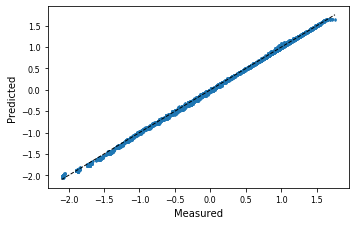

Final score (MSE): 0.0007255594050467008
Final score (MAE): 0.020949105280490217
Final score (RMSE): 0.026936209923571295


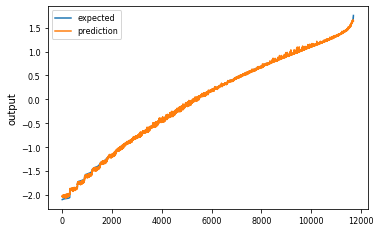

In [107]:
# Predict
print("[INFO] predicting...")
t0 = time.time()
pred = model.predict(x_test)
regr_predict = time.time() - t0
print("Prediction for %d inputs in %.6f s" % (x_test.shape[0], regr_predict))

fig, ax = plt.subplots()
ax.scatter(y_test, pred, s=2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

score = metrics.mean_squared_error(pred, y_test)
print("Final score (MSE): {}".format(score))

score = metrics.mean_absolute_error(pred, y_test)
print("Final score (MAE): {}".format(score))

score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Final score (RMSE): {}".format(score))

# Regression chart
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.tight_layout()
    plt.savefig("adim_regression.pdf", dpi=150)
    plt.show()

# Plot regression chart
chart_regression(pred.flatten(), y_test)

### Save the model

In [108]:
model.save('shear_keras_model.h5', include_optimizer=False)